In [17]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
%autoreload 2
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.decomposition import PCA
import torch
from tqdm.auto import tqdm

import sys
sys.path.append('/om2/user/eisenaj/code/TransformersInDisguise')
from data_simulation import TimeSeriesDataset
from train import *

In [19]:
def multiple_simulations(dynamics, N, t_span, t_eval, num_sims=1, initial_scale=1, initial_shift_scale=0, dynamics_kwargs={}, verbose=True):
    x = np.zeros((num_sims, len(t_eval), N))
    for sim_num in tqdm(range(num_sims), disable=not verbose, desc='simulating system trajectories'):
        x0 = np.random.randn(N)*initial_scale
        shift = np.random.randn(N)*initial_shift_scale
        x0 += shift

        sol = solve_ivp(lambda t, x: dynamics(t, x, **dynamics_kwargs), t_span=t_span, y0=x0, t_eval=t_eval)
        x[sim_num] = sol.y.T
    
    return x

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class SimpleEnergyNetwork(torch.nn.Module):
    def __init__(
            self,
            input_dim,
            num_hidden_units,
            beta=None,
            initial_scale=1,
        ):
        super(SimpleEnergyNetwork, self).__init__()

        self.MODEL_TYPE='SimpleEnergyNetwork'

        if beta is None:
            self.beta = 1/np.sqrt(input_dim)
        elif beta == 'learned':
            self.beta = torch.nn.Parameter(torch.randn(1)*initial_scale)
        else:
            self.beta = beta

        self.input_dim = input_dim
        self.num_hidden_units = num_hidden_units
        
        self.X = torch.nn.Parameter(torch.randn(input_dim, num_hidden_units)*initial_scale)
        self.softmax = torch.nn.Softmax(dim=1)
    
    def forward(self, Xi):
        # chi comes in as batch_size x sequence_length x input_dim
        return (self.X @ self.softmax(torch.abs(self.beta)*self.X.T @ Xi.transpose(-2, -1))).transpose(-2, -1)
    
    def energy(self, Xi):
        with torch.no_grad():
            N = self.num_hidden_units
            M = torch.norm(self.X, dim=0).max()
            return -torch.logsumexp(torch.abs(self.beta)*self.X.T @ Xi.transpose(-2, -1), dim=1) + 0.5*(Xi*Xi).sum(dim=-1) + (1/self.beta)*np.log(N) + 0.5*(M**2)
    
    def generate(self, x_context, pred_length, eval_mode=False):
        if eval_mode:
            self.eval()  # Put the model in evaluation mode
        
        # Ensure x_context has shape (batch_size, sequence_length, input_dim)
        x_context = x_context.unsqueeze(0) if len(x_context.size()) == 2 else x_context
        
        generated_output = torch.zeros(x_context.size(0), pred_length, x_context.size(2)).to(x_context.device)
        
        # Run the transformer on the context input
        initial_output = self(x_context)

        generated_step = initial_output[:, [-1]]
        x_context = torch.cat((x_context, generated_step), dim=1)
        
        # Generate future time steps
        for i in range(pred_length):
            
            # Run the transformer and take the last step
            generated_output[:, [i]] = self(x_context[:, [-1]])[:, [-1]]
            
            # Append the generated step to the context for the next iteration
            x_context = torch.cat((x_context, generated_output[:, [i]]), dim=1)
        
        if eval_mode:
            self.train()  # Return the model to training mode

        return torch.cat((initial_output, generated_output), dim=1)

# Analyze

In [21]:
def simple_system(t, x, lamb=-3, mu=-2, k=0):
    return [mu*(x[0] - k), lamb*(x[1] - x[0]**2)]

def rnn(t, x, W, tau):
    return (1/tau)*(-x + W @ np.tanh(x))

def duffing_oscillator(t, x, alpha=-1, beta=1):
    return [x[1], -alpha*x[0] - beta*x[0]**3]

In [22]:
# ------------------
# SIMPLE SYSTEM
# ------------------
t_span = [0, 10]
dt = 0.01
t_eval = np.arange(t_span[0], t_span[1], dt)
dynamics_kwargs = dict(
    lamb=-3,
    mu=-2,
    k=2
)

N = 2

x = multiple_simulations(simple_system, N, t_span, t_eval, num_sims=1000, initial_scale=2, dynamics_kwargs=dynamics_kwargs)

# # ------------------
# # TWO DIM RNN
# # ------------------

# t_span = [0, 10]
# dt = 0.001
# t_eval = np.arange(t_span[0], t_span[1], dt)

# N = 2

# B = np.random.rand(N, N)/np.sqrt(N)
# W = B.T @ B

# # W  = 0
# # for i in range(2):
# #     x = np.random.randn(N)
# #     W += np.outer(x, x)
# # W /= N

# dynamics_kwargs = dict(
#     W=W,
#     tau=0.4,
# )

# x = multiple_simulations(rnn, N, t_span, t_eval, num_sims=1000, initial_scale=10, dynamics_kwargs=dynamics_kwargs)



simulating system trajectories:   0%|          | 0/1000 [00:00<?, ?it/s]

In [23]:
# x = (x - x.mean(axis=(0, 1)))/x.std(axis=(0, 1))

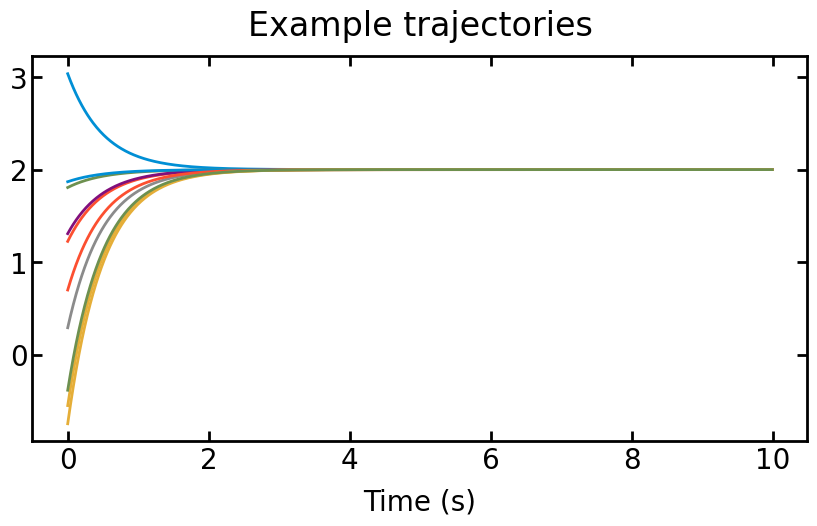

In [24]:
time_vals = np.arange(x.shape[1])*dt
sample_inds = np.random.choice(x.shape[0], 10, replace=False)
plt.plot(time_vals, x[sample_inds, :, 0].T)
plt.title('Example trajectories')
plt.xlabel('Time (s)')
plt.show()

In [25]:
# subsample = 10
subsample = 1
dt = (t_eval[1] - t_eval[0])*subsample
pts = x[:, ::subsample, :]

In [26]:
# seq_length = 900
seq_length = 999
context_length = 0
seq_spacing = 1

train_examples = []
labels = []
iterator = tqdm(total=pts.shape[0]*len(np.arange(0, pts.shape[1] - seq_length, seq_spacing)), desc='creating training examples')
for traj_num in range(pts.shape[0]):
    for start_ind in np.arange(0, pts.shape[1] - seq_length, seq_spacing):
        train_examples.append(pts[traj_num, start_ind:start_ind + seq_length])
        labels.append(pts[traj_num, start_ind + 1:start_ind + seq_length + 1])
        iterator.update(1)
iterator.close()
train_examples = np.array(train_examples)
labels = np.array(labels)

dataset = TimeSeriesDataset(torch.from_numpy(train_examples), torch.from_numpy(labels))

creating training examples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [27]:
train_percent = 0.8
batch_size = 32

train_size = int(train_percent*len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Train

In [28]:
model_kwargs = dict(
    input_dim=N,
    num_hidden_units=100,
    beta='learned'
)
model = SimpleEnergyNetwork(**model_kwargs)

print(f"{model.MODEL_TYPE} has {count_parameters(model)} trainable parameters")

SimpleEnergyNetwork has 201 trainable parameters


In [29]:
model.eval()

SimpleEnergyNetwork(
  (softmax): Softmax(dim=1)
)

In [30]:
device = 'cuda'
dtype = torch.FloatTensor

In [31]:
EPOCHS = 10
learning_rate = 1e-3
test_step = 1
context_length = 1
opt_model, loss_curve = train_model(
    model,
    train_data_loader,
    test_data_loader,
    EPOCHS=EPOCHS,
    learning_rate=learning_rate,
    test_step=test_step,
    context_length=context_length,
    device=device,
    mode='chained',
    verbose=2
)

Training:   0%|          | 0/250 [00:00<?, ?it/s]

--------------------
EPOCH 1
train loss = 11.35040
test loss = 2.22414
test loss final step = 2.48333
--------------------
EPOCH 2
train loss = 10.75947
test loss = 2.22915
test loss final step = 2.50277
--------------------
EPOCH 3
train loss = 10.20412
test loss = 2.16413
test loss final step = 2.43277
--------------------
EPOCH 4
train loss = 9.65132
test loss = 2.11129
test loss final step = 2.31344
--------------------
EPOCH 5
train loss = 9.04930
test loss = 2.00490
test loss final step = 2.17115
--------------------
EPOCH 6
train loss = 8.18671
test loss = 1.77436
test loss final step = 1.98847
--------------------
EPOCH 7
train loss = 4.73488
test loss = 1.58480
test loss final step = 1.77994
--------------------
EPOCH 8
train loss = 2.86309
test loss = 1.49058
test loss final step = 1.66650
--------------------
EPOCH 9
train loss = 2.51278
test loss = 1.41135
test loss final step = 1.58781
--------------------
EPOCH 10
train loss = 2.30371
test loss = 1.37197
test loss final s

# Test

## One Step

In [32]:
all_test_outputs = np.zeros((len(test_dataset), seq_length, test_dataset[0][0].shape[-1]))
all_test_labels = np.zeros((len(test_dataset), seq_length, test_dataset[0][0].shape[-1]))

index = 0
for batch_data, labels in tqdm(test_data_loader):
    batch_data = batch_data.type(dtype).to(device)
    labels = labels.type(dtype).to(device)

    if opt_model.MODEL_TYPE == 'LSTM':
        outputs, hiddens = opt_model(batch_data)
    else:
        outputs = opt_model(batch_data)

    all_test_outputs[index:index + outputs.shape[0]] = outputs.detach().cpu().numpy()
    all_test_labels[index:index + outputs.shape[0]] = labels.detach().cpu().numpy()
    index += outputs.shape[0]

  0%|          | 0/7 [00:00<?, ?it/s]

In [33]:
system_kwargs = {'dt': dt}

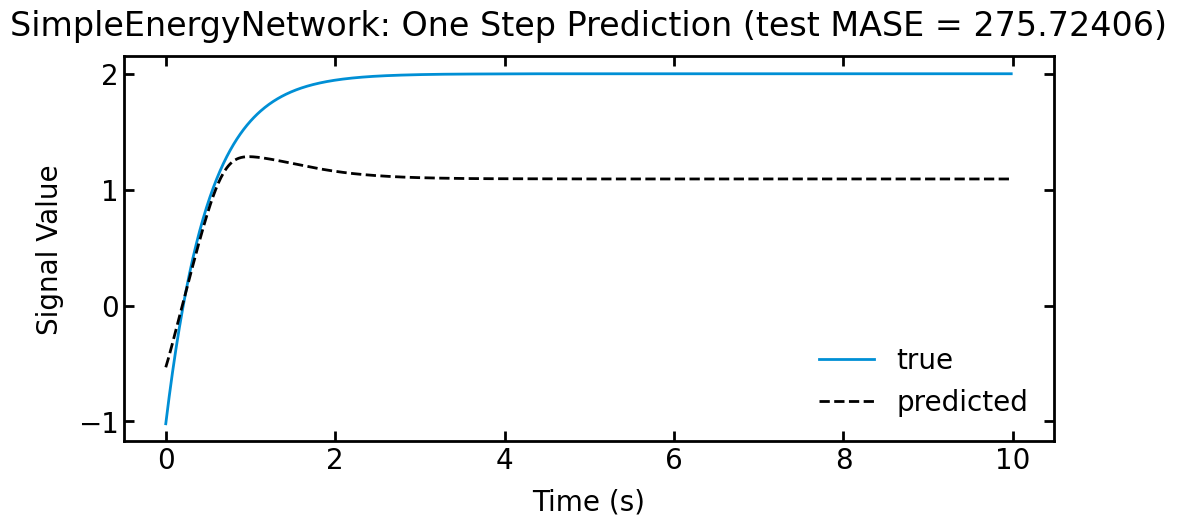

In [35]:
plt.figure(figsize=(12, 5))
plt.plot((np.arange(seq_length)*system_kwargs['dt']), all_test_labels[0, :, 0], label='true')
plt.plot((np.arange(seq_length)*system_kwargs['dt']), all_test_outputs[0, :, 0], c='k', linestyle='--', label=f'predicted')
# plt.plot((np.arange(seq_length)*system_kwargs['dt'])[1:], all_test_labels[0, :-1, 0], alpha=0.6, label=f'persistence baseline (test MSE = {((labels[:, :-1] - labels[:, 1:])**2).mean():.5f})')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Signal Value')
plt.title(f"{opt_model.MODEL_TYPE}: One Step Prediction (test MASE = {(np.abs(all_test_outputs - all_test_labels)).mean()/(np.abs(all_test_labels[:, :-1] - all_test_labels[:, 1:])).mean():.5f})")
plt.show()

## Chained

In [36]:
chained_context_length = 50

In [37]:
# FINAL TEST CHAINED
with torch.no_grad():
    all_test_outputs = np.zeros((len(test_dataset), seq_length, test_dataset[0][0].shape[-1]))
    all_test_labels = np.zeros((len(test_dataset), seq_length, test_dataset[0][0].shape[-1]))
    
    pred_length = seq_length - chained_context_length
    
    index = 0
    for batch_data, labels in tqdm(test_data_loader):
        batch_data = batch_data.type(dtype).to(device)
        labels = labels.type(dtype).to(device)
        with torch.no_grad():
            if opt_model.MODEL_TYPE == 'LSTM':
                outputs, hiddens = opt_model.generate(batch_data[:, :chained_context_length], pred_length=pred_length, eval_mode=True)
            else:
                outputs = opt_model.generate(batch_data[:, :chained_context_length], pred_length=pred_length, eval_mode=True)
        

        all_test_outputs[index:index + outputs.shape[0]] = outputs.detach().cpu().numpy()
        all_test_labels[index:index + outputs.shape[0]] = labels.detach().cpu().numpy()
        index += outputs.shape[0]

  0%|          | 0/7 [00:00<?, ?it/s]

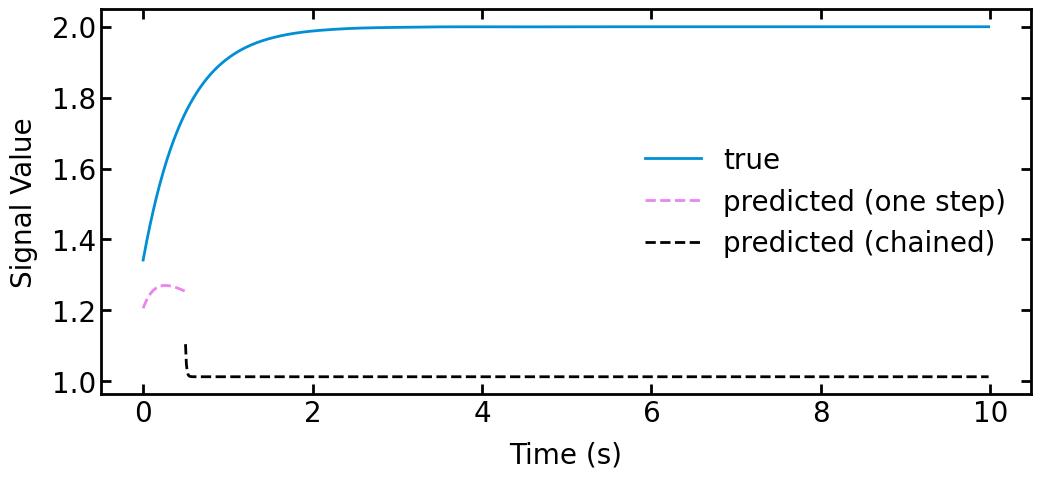

In [38]:
plt.figure(figsize=(12, 5))
time_vals = (np.arange(seq_length)*system_kwargs['dt'])
index = 0
test_ind =16
plt.plot(time_vals, all_test_labels[test_ind, :, index], label='true')
# plt.plot(time_vals[:context_length +1], all_test_outputs[0, :context_length + 1, 0], c='purple', linestyle='--', label=f'predicted (context)')
plt.plot(time_vals[:chained_context_length], all_test_outputs[test_ind, :chained_context_length, index], c='violet', linestyle='--', label=f'predicted (one step)')
plt.plot(time_vals[chained_context_length:], all_test_outputs[test_ind, chained_context_length:, index], c='k', linestyle='--', label=f'predicted (chained)')
# plt.plot(time_vals, labels[0, :-1, 0].detach().cpu().numpy(), alpha=0.6, label=f'persistence baseline (test MSE = {criterion(labels[:, :-1], labels[:, 1:]):.5f})')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Signal Value')
# plt.title(f"{opt_model.MODEL_TYPE}: Chained Prediction (test MASE = {(np.abs(all_test_outputs - all_test_labels)).mean()/(np.abs(all_test_labels[:, :-1] - all_test_labels[:, 1:])).mean():.5f})")
plt.show()

# Energy

## Generated Trajectory Energy

In [39]:
with torch.no_grad():
    energy_trajs = np.zeros((all_test_outputs.shape[0], seq_length))
    
    num_batches = int(np.ceil(all_test_outputs.shape[0]/batch_size))
    for index in tqdm(range(num_batches)):
        batch_data = torch.from_numpy(all_test_outputs[index*batch_size:(index + 1)*batch_size]).type(dtype).to(device)
        
        outputs = opt_model.energy(batch_data)
        
        energy_trajs[index:index + outputs.shape[0]] = outputs.detach().cpu().numpy()
        index += outputs.shape[0]

  0%|          | 0/7 [00:00<?, ?it/s]

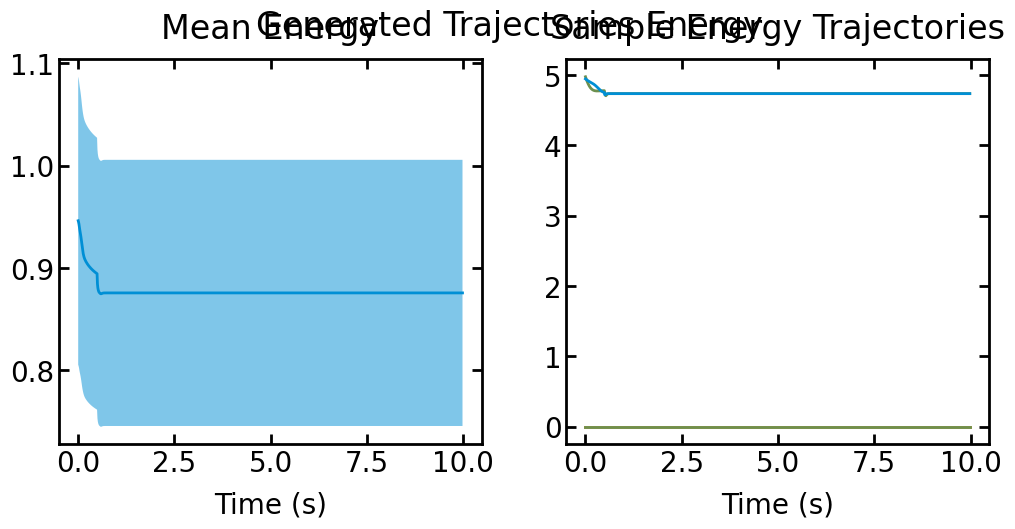

In [40]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
time_vals = (np.arange(seq_length)*system_kwargs['dt'])
mean_vals = energy_trajs.mean(axis=0)
standard_error = energy_trajs.std(axis=0)/np.sqrt(energy_trajs.shape[0])
plt.plot(time_vals, energy_trajs.mean(axis=0))
plt.fill_between(time_vals, mean_vals - standard_error, mean_vals + standard_error, alpha=0.5)
plt.title('Mean Energy')
plt.xlabel('Time (s)')

plt.subplot(1, 2, 2)
num_samples = 10
sample_inds = np.random.choice(energy_trajs.shape[0], size=num_samples, replace=False)
time_vals = (np.arange(seq_length)*system_kwargs['dt'])
# sample_inds = [16]
for sample_ind in sample_inds:
    plt.plot(time_vals, energy_trajs[sample_ind])
plt.title('Sample Energy Trajectories')
plt.xlabel('Time (s)')
plt.suptitle('Generated Trajectories Energy')
plt.show()

## Train Energy

In [41]:
with torch.no_grad():
    energy_trajs = np.zeros((len(train_dataset), seq_length))
    
    pred_length = seq_length - chained_context_length
    
    index = 0
    for batch_data, _ in tqdm(train_data_loader):
        batch_data = batch_data.type(dtype).to(device)
        
        outputs = opt_model.energy(batch_data)
        

        energy_trajs[index:index + outputs.shape[0]] = outputs.detach().cpu().numpy()
        index += outputs.shape[0]

  0%|          | 0/25 [00:00<?, ?it/s]

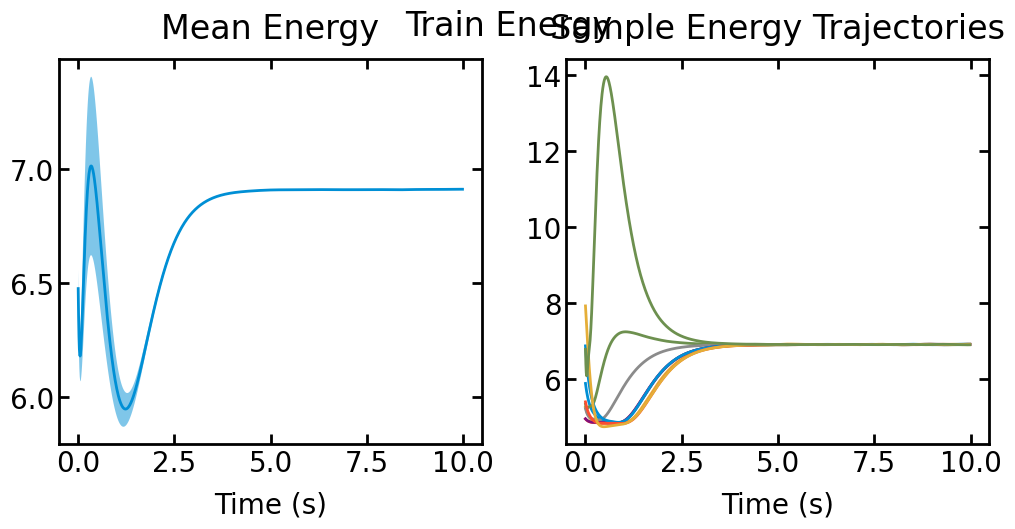

In [42]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
time_vals = (np.arange(seq_length)*system_kwargs['dt'])
mean_vals = energy_trajs.mean(axis=0)
standard_error = energy_trajs.std(axis=0)/np.sqrt(energy_trajs.shape[0])
plt.plot(time_vals, energy_trajs.mean(axis=0))
plt.fill_between(time_vals, mean_vals - standard_error, mean_vals + standard_error, alpha=0.5)
plt.title('Mean Energy')
plt.xlabel('Time (s)')

plt.subplot(1, 2, 2)
num_samples = 10
sample_inds = np.random.choice(energy_trajs.shape[0], size=num_samples, replace=False)
time_vals = (np.arange(seq_length)*system_kwargs['dt'])
for sample_ind in sample_inds:
    plt.plot(time_vals, energy_trajs[sample_ind])
plt.title('Sample Energy Trajectories')
plt.xlabel('Time (s)')
plt.suptitle('Train Energy')
plt.show()

## Test Energy

In [43]:
with torch.no_grad():
    energy_trajs = np.zeros((len(test_dataset), seq_length))
    
    pred_length = seq_length - chained_context_length
    
    index = 0
    for batch_data, _ in tqdm(test_data_loader):
        batch_data = batch_data.type(dtype).to(device)
        
        outputs = opt_model.energy(batch_data)
        

        energy_trajs[index:index + outputs.shape[0]] = outputs.detach().cpu().numpy()
        index += outputs.shape[0]

  0%|          | 0/7 [00:00<?, ?it/s]

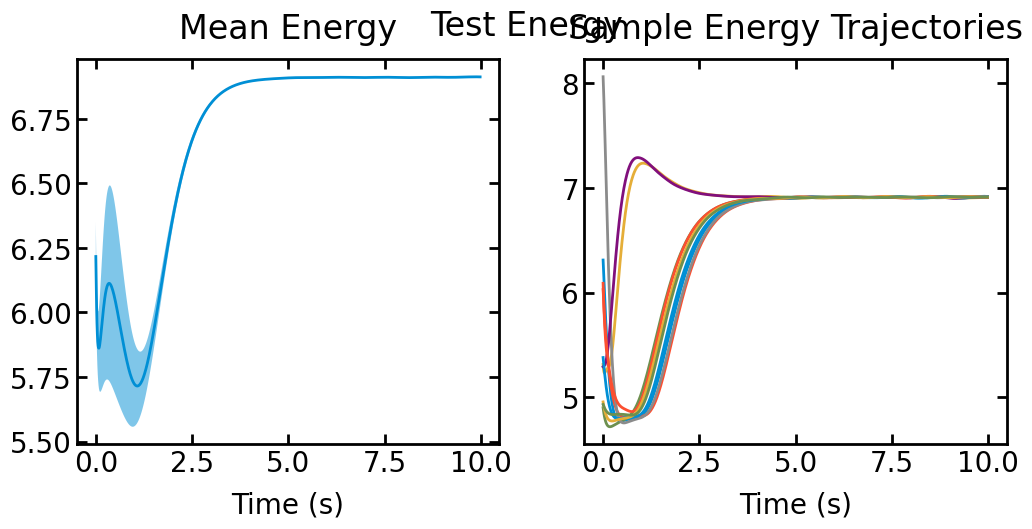

In [44]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
time_vals = (np.arange(seq_length)*system_kwargs['dt'])
mean_vals = energy_trajs.mean(axis=0)
standard_error = energy_trajs.std(axis=0)/np.sqrt(energy_trajs.shape[0])
plt.plot(time_vals, energy_trajs.mean(axis=0))
plt.fill_between(time_vals, mean_vals - standard_error, mean_vals + standard_error, alpha=0.5)
plt.title('Mean Energy')
plt.xlabel('Time (s)')

plt.subplot(1, 2, 2)
num_samples = 10
sample_inds = np.random.choice(energy_trajs.shape[0], size=num_samples, replace=False)
time_vals = (np.arange(seq_length)*system_kwargs['dt'])
for sample_ind in sample_inds:
    plt.plot(time_vals, energy_trajs[sample_ind])
plt.title('Sample Energy Trajectories')
plt.xlabel('Time (s)')

plt.suptitle('Test Energy')

plt.show()

## Landscape

In [45]:
all_pts = np.vstack(pts)
sample_inds = np.random.choice(all_pts.shape[0], 10000, replace=False)
# pca = PCA(n_components=N).fit(all_pts[sample_inds])

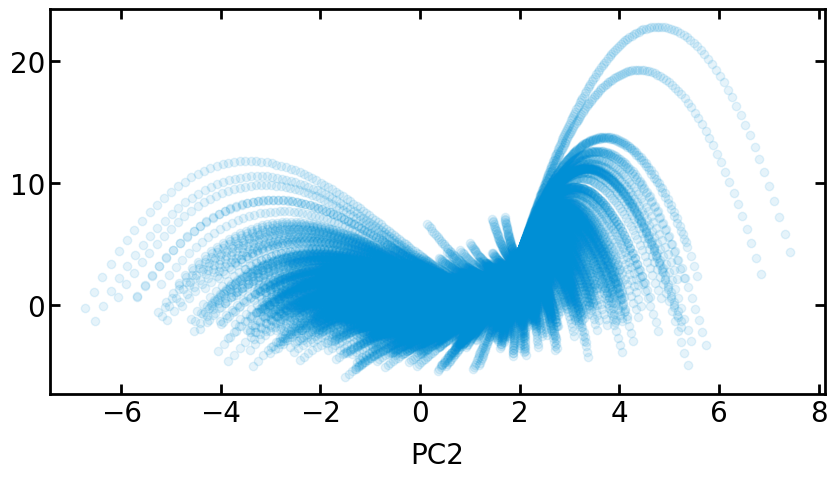

In [56]:
# pca_pts = pca.transform(all_pts)[:, :2]
pca_pts = all_pts
plt.scatter(pca_pts[:, 0], pca_pts[:, 1], alpha=0.1)
plt.xlabel('PC1')
plt.xlabel('PC2')
plt.show()

In [57]:
# grid_pts = torch.linspace(-10, 10, 101)
# X, Y = torch.meshgrid(grid_pts, grid_pts, indexing='xy')
scale=1
x_grid_pts = torch.linspace(pca_pts[:, 0].min(), pca_pts[:, 0].max(), 101)*scale
y_grid_pts = torch.linspace(pca_pts[:, 1].min(), pca_pts[:, 1].max(), 101)*scale
# x_grid_pts = torch.linspace(-1, 1, 101)*scale
# y_grid_pts = torch.linspace(-1, 1, 101)*scale
X, Y = torch.meshgrid(x_grid_pts, y_grid_pts, indexing='xy')

In [58]:
energy_landscape = torch.zeros(X.shape)

iterator = tqdm(total=X.shape[0]*X.shape[1])

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        # energy_landscape[i, j] = model.energy(torch.tensor([X[i, j], Y[i, j]]).type(dtype).to('cuda').unsqueeze(0).unsqueeze(0)).squeeze().squeeze()
        pt = torch.from_numpy(pca.inverse_transform(np.hstack([np.array([X[i, j], Y[i, j]]), np.zeros(N - 2)])))
        energy_landscape[i, j] = model.energy(pt.type(dtype).to('cuda').unsqueeze(0).unsqueeze(0)).squeeze().squeeze()
        iterator.update()
iterator.close()

  0%|          | 0/10201 [00:00<?, ?it/s]

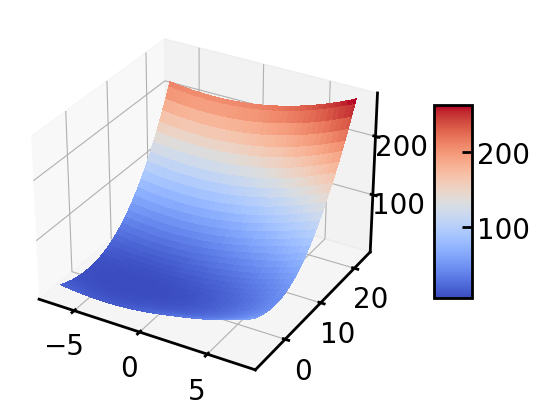

In [59]:
# Plot the surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, energy_landscape, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [50]:
stored_patterns_pca = pca.transform(opt_model.X.T.cpu().detach())

In [51]:
true_fixed_pt = pca.transform(np.array([[2,4]]))

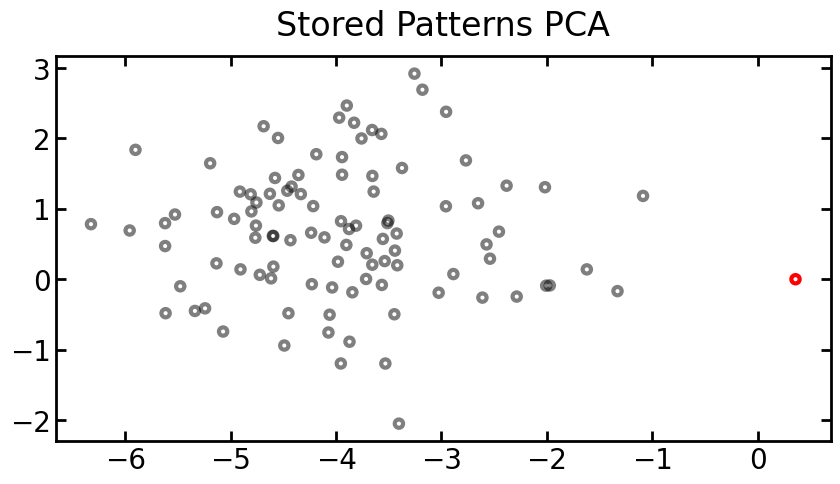

In [52]:
plt.scatter(stored_patterns_pca[:, 0], stored_patterns_pca[:, 1], marker='o', facecolors='none', edgecolors='k', lw=3, alpha=0.5)
plt.scatter(true_fixed_pt[:, 0], true_fixed_pt[:, 1], facecolors='none', edgecolors='r', lw=3)
plt.title('Stored Patterns PCA')
plt.show()